In [ ]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [2]:
ind="stashcp-2016.7"
#new data
myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467834066930,
                  "lte": 1467842419537,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

#10 mins
myquery2={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467907180460,
                  "lte": 1467917189389,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

In [3]:
page= es.search(index=ind, body=myquery2, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

df = pd.DataFrame(Res)
#print(df.head(2))

del df['destination_space']
del df['xrdcp_version']
#del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
#del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(list(df.columns.values))
print(df.head(1))

1001
['cache', 'download_time', 'end1', 'end2', 'filename', 'host', 'sitename', 'start1', 'start2', 'start3', 'status', 'timestamp', 'tries', 'xrdexit1', 'xrdexit2', 'xrdexit3', 'begin']
                      cache download_time           end1 end2  \
0  root://hcc-stash.unl.edu         19513  1467907629725    0   

                            filename                      host       sitename  \
0  user/taburaad/public/2gb_file.tar  root://hcc-stash.unl.edu  Sandhills-CE1   

          start1 start2 start3   status      timestamp tries xrdexit1  \
0  1467907610212      0      0  Success  1467907629000     1        0   

  xrdexit2 xrdexit3          begin  
0       -1       -1  1467907609487  


In [4]:
length=df.shape[0]

for i in range(length):
    begin=int(df['begin'].iloc[i])//1000
    end=int(df['timestamp'].iloc[i])//1000
    start1=int(df['start1'].iloc[i])//1000
    end1=int(df['end1'].iloc[i])//1000
    start2=int(df['start2'].iloc[i])//1000
    end2=int(df['end2'].iloc[i])//1000
    start3=int(df['start3'].iloc[i])//1000
    df['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
    df['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')  
    df['start1'].iloc[i]=datetime.datetime.fromtimestamp(start1).strftime('%Y-%m-%d %H:%M:%S')
    df['start2'].iloc[i]=datetime.datetime.fromtimestamp(start2).strftime('%Y-%m-%d %H:%M:%S')
    df['start3'].iloc[i]=datetime.datetime.fromtimestamp(start3).strftime('%Y-%m-%d %H:%M:%S')
    df['end1'].iloc[i]=datetime.datetime.fromtimestamp(end1).strftime('%Y-%m-%d %H:%M:%S')
    df['end2'].iloc[i]=datetime.datetime.fromtimestamp(end2).strftime('%Y-%m-%d %H:%M:%S')


    
df=df.set_index(['timestamp'])    
df.index = pd.to_datetime(df.index, unit='s')
df['begin']=pd.to_datetime(df.begin, unit='s')
df['start1']=pd.to_datetime(df.begin, unit='s')
df['start2']=pd.to_datetime(df.begin, unit='s')
df['start3']=pd.to_datetime(df.begin, unit='s')
df['end1']=pd.to_datetime(df.begin, unit='s')
df['end2']=pd.to_datetime(df.begin, unit='s')
df

/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,cache,download_time,end1,end2,filename,host,sitename,start1,start2,start3,status,tries,xrdexit1,xrdexit2,xrdexit3,begin
timestamp,,,,,,,,,,,,,,,,
2016-07-07 11:07:09,root://hcc-stash.unl.edu,19513,2016-07-07 11:06:49,2016-07-07 11:06:49,user/taburaad/public/2gb_file.tar,root://hcc-stash.unl.edu,Sandhills-CE1,2016-07-07 11:06:49,2016-07-07 11:06:49,2016-07-07 11:06:49,Success,1,0,-1,-1,2016-07-07 11:06:49
2016-07-07 11:08:24,root://hcc-stash.unl.edu,18404,2016-07-07 11:08:05,2016-07-07 11:08:05,user/taburaad/public/2gb_file.tar,root://hcc-stash.unl.edu,Sandhills-CE1,2016-07-07 11:08:05,2016-07-07 11:08:05,2016-07-07 11:08:05,Success,1,0,-1,-1,2016-07-07 11:08:05
2016-07-07 11:08:29,root://mwt2-stashcache.campuscluster.illinois.edu,101378,2016-07-07 11:06:47,2016-07-07 11:06:47,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,FIU_HPCOSG_CE,2016-07-07 11:06:47,2016-07-07 11:06:47,2016-07-07 11:06:47,Success,1,0,-1,-1,2016-07-07 11:06:47
2016-07-07 11:08:31,root://data.ci-connect.net,28813,2016-07-07 11:08:02,2016-07-07 11:08:02,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,AGLT2_CE_2,2016-07-07 11:08:02,2016-07-07 11:08:02,2016-07-07 11:08:02,Success,1,0,-1,-1,2016-07-07 11:08:02
2016-07-07 11:08:39,root://hcc-stash.unl.edu,45291,2016-07-07 11:07:53,2016-07-07 11:07:53,user/taburaad/public/2gb_file.tar,root://hcc-stash.unl.edu,Tusker-CE1,2016-07-07 11:07:53,2016-07-07 11:07:53,2016-07-07 11:07:53,Success,1,0,-1,-1,2016-07-07 11:07:53
2016-07-07 11:08:41,root://hcc-stash.unl.edu,52021,2016-07-07 11:07:48,2016-07-07 11:07:48,user/taburaad/public/2gb_file.tar,root://hcc-stash.unl.edu,Tusker-CE1,2016-07-07 11:07:48,2016-07-07 11:07:48,2016-07-07 11:07:48,Success,1,0,-1,-1,2016-07-07 11:07:48
2016-07-07 11:08:42,root://hcc-stash.unl.edu,49329,2016-07-07 11:07:52,2016-07-07 11:07:52,user/taburaad/public/2gb_file.tar,root://hcc-stash.unl.edu,Tusker-CE1,2016-07-07 11:07:52,2016-07-07 11:07:52,2016-07-07 11:07:52,Success,1,0,-1,-1,2016-07-07 11:07:52
2016-07-07 11:08:50,root://data.ci-connect.net,15868,2016-07-07 11:08:34,2016-07-07 11:08:34,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-07 11:08:34,2016-07-07 11:08:34,2016-07-07 11:08:34,Success,1,0,-1,-1,2016-07-07 11:08:34
2016-07-07 11:08:58,root://hcc-stash.unl.edu,15811,2016-07-07 11:08:42,2016-07-07 11:08:42,user/taburaad/public/2gb_file.tar,root://hcc-stash.unl.edu,red-gateway2,2016-07-07 11:08:42,2016-07-07 11:08:42,2016-07-07 11:08:42,Success,1,0,-1,-1,2016-07-07 11:08:42


In [5]:
df.to_pickle('newdata.pkl') 

type(df['start1'].iloc[1])

pandas.tslib.Timestamp

In [ ]:
jobs = pd.concat([pd.Series(1, df.begin), pd.Series(-1, df.index)]).resample('1Min', how='sum').cumsum()
index=jobs.index

df2=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC', 'BNL ATLAS', 'FZU', 'Trunk'])
finish=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC', 'BNL ATLAS', 'FZU', 'Trunk'])

df2['index']=index
finish['index']=index

length2=df2.shape[0]
df2['Origin']=0
df2['Nebraska']=0
df2['UCSD']=0
df2['US-MWT2_UIUC']=0
df2['BNL ATLAS']=0
df2['FZU']=0
df2['Trunk']=0
finish['Origin']=0
finish['Nebraska']=0
finish['UCSD']=0
finish['US-MWT2_UIUC']=0
finish['BNL ATLAS']=0
finish['FZU']=0
finish['Trunk']=0
finish['Timeout']=0


for i in range(length2):
    for j in range(length):
        if df['tries'].iloc[j]=="1":
            if df['begin'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['host'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
                if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['host'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['host'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
        if df['tries'].iloc[j]!="1":
            if df['start2'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['cache'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['cache'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://data.ci-connect.net':
                    if df['tries'].iloc[j]=="2":
                        df2['Origin'].iloc[i]+=1
                    else:
                        df2['Trunk'].iloc[i]+=1
        if df.index[j].replace(second=0, microsecond=0)==finish['index'].iloc[i].replace(second=0, microsecond=0):
            if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                finish['Nebraska'].iloc[i]+=1
            if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                finish['US-MWT2_UIUC'].iloc[i]+=1
            if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                finish['UCSD'].iloc[i]+=1
            if df['host'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                finish['BNL ATLAS'].iloc[i]+=1
            if df['host'].iloc[j]=='novastore.farm.particle.cz':
                finish['FZU'].iloc[i]+=1
            if df['host'].iloc[j]=='root://data.ci-connect.net':
                if df['status'].iloc[j]=='Timeout':
                    finish['Timeout'].iloc[i]+=1
                else:
                    if df['tries'].iloc[j]=="1" or df['tries'].iloc[j]=="2":
                        finish['Origin'].iloc[i]+=1
                    elif df['tries'].iloc[j]=="3":
                        finish['Trunk'].iloc[i]+=1




/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':
/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
finish

,index,Origin,Nebraska,UCSD,US-MWT2_UIUC,BNL ATLAS,FZU,Trunk,Timeout
0,2016-07-07 11:05:00,1,0,0,0,0,0,0,0
1,2016-07-07 11:06:00,3,0,0,0,0,0,0,0
2,2016-07-07 11:07:00,10,9,0,3,0,0,0,0
3,2016-07-07 11:08:00,7,11,0,7,0,0,1,0
4,2016-07-07 11:09:00,19,12,0,9,0,0,0,0
5,2016-07-07 11:10:00,18,12,0,14,0,0,0,0
6,2016-07-07 11:11:00,14,22,0,7,0,0,0,0
7,2016-07-07 11:12:00,17,23,3,2,0,0,0,0
8,2016-07-07 11:13:00,19,25,7,8,0,0,0,0
9,2016-07-07 11:14:00,17,25,13,12,0,0,0,0


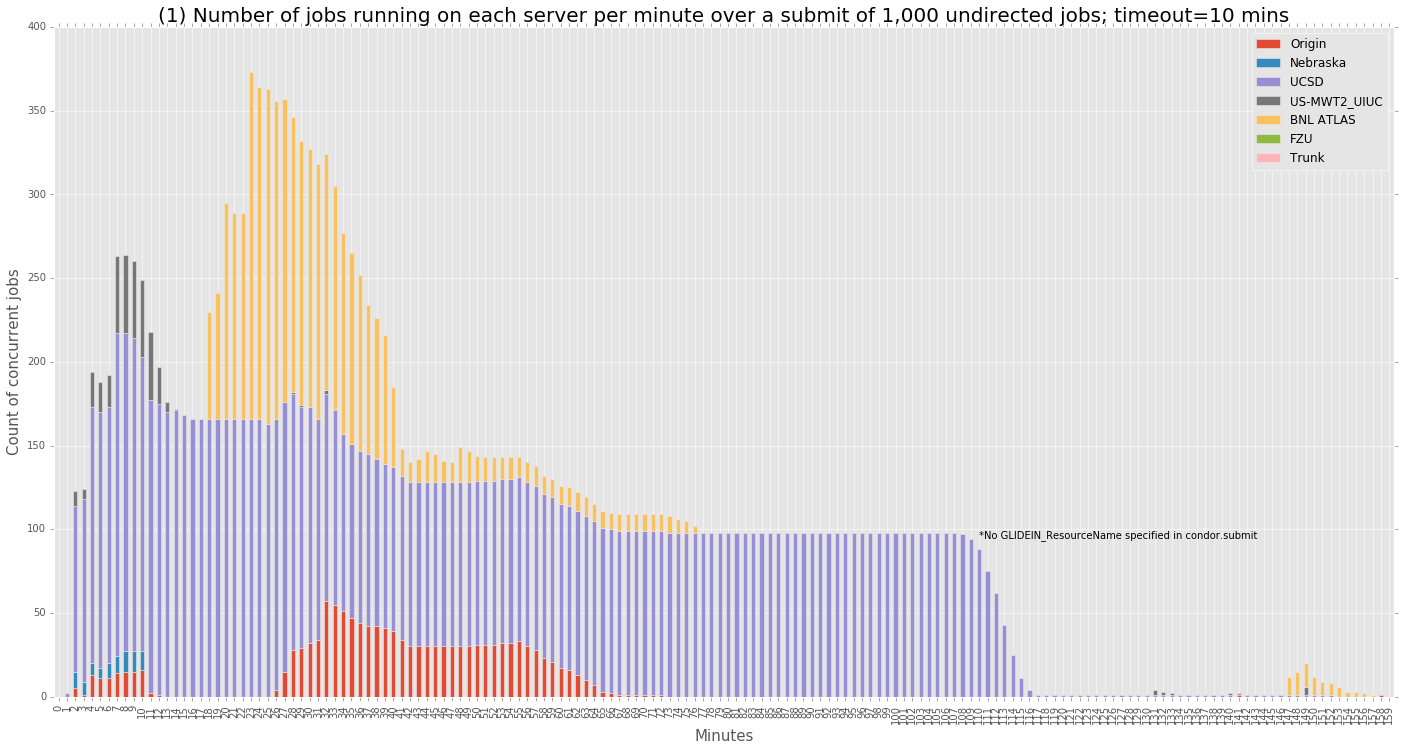

In [19]:
df2.plot.bar(stacked=True,figsize=[24, 12])
plt.title('(1) Number of jobs running on each server per minute over a submit of 1,000 undirected jobs; timeout=10 mins', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of concurrent jobs',fontsize=15)
plt.text(110,95,'*No GLIDEIN_ResourceName specified in condor.submit')
plt.savefig('undirected_concurrent_10mins.png')


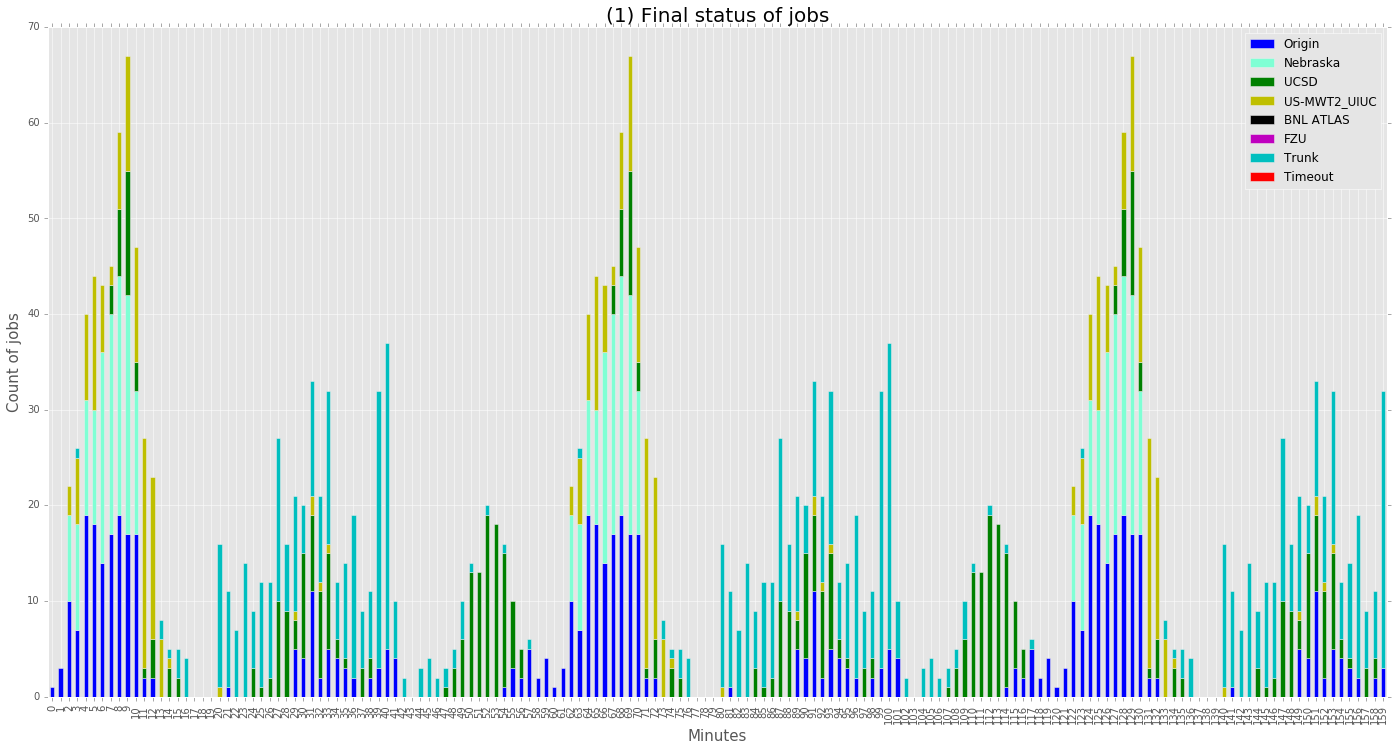

In [18]:
finish.plot.bar(stacked=True,figsize=[24, 12],color=['b', '#7FFFD4', 'g', 'y', 'k', 'm', 'c', 'r'])
plt.title('(1) Final status of jobs', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of jobs',fontsize=15)

In [25]:
print(df.index[1].time())
df.index[1]

dtwithoutseconds = df.index[1].replace(second=0, microsecond=0)
print(dtwithoutseconds)

11:08:24
2016-07-07 11:08:00
